# Libaries

In [2]:
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import seaborn            as sns
import time
import os
from mpl_toolkits.mplot3d import Axes3D

# Dataset

In [3]:
results_path = '../../../LargeFilesResults/Model'
posteriors   = pd.read_csv(os.path.join(results_path, 'betas_allZ_sharedprior_sc.csv'))

In [4]:
fit_summary  = '../../../LargeFilesResults/Model/fit_summary_allZ_sharedprior_sc.csv'
masses       = np.loadtxt(fit_summary, delimiter=',', usecols=[-1], skiprows=1, dtype=float)
redshifts    = np.loadtxt(fit_summary, delimiter=',', usecols=[-2], skiprows=1, dtype=float)
param_header = np.loadtxt(fit_summary, delimiter=',', dtype=str)[0,-2:]
fit_header   = pd.read_csv(os.path.join(results_path, 'entirefit_allZ_sharedpriors_sc.csv'), nrows=1).columns

In [5]:
grid       = np.column_stack([redshifts, masses])
grid_split = np.array_split(grid, 5)
grid_split[0].shape

(900, 2)

# Output paths

In [6]:
figs_path = '../../../Figs/FigsSharedPrior/'

In [7]:
dimensions = posteriors.columns.values.reshape(5,5)
rows       = dimensions[:,0].size
columns    = dimensions[0,:].size

In [8]:
whan_classes = ['Not classified', 'Retired/Passive', 'wAGN', 'sAGN', 'SF']
palette      = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8','#984ea3']
figsize      = (20, 20)
alpha        = 0.4

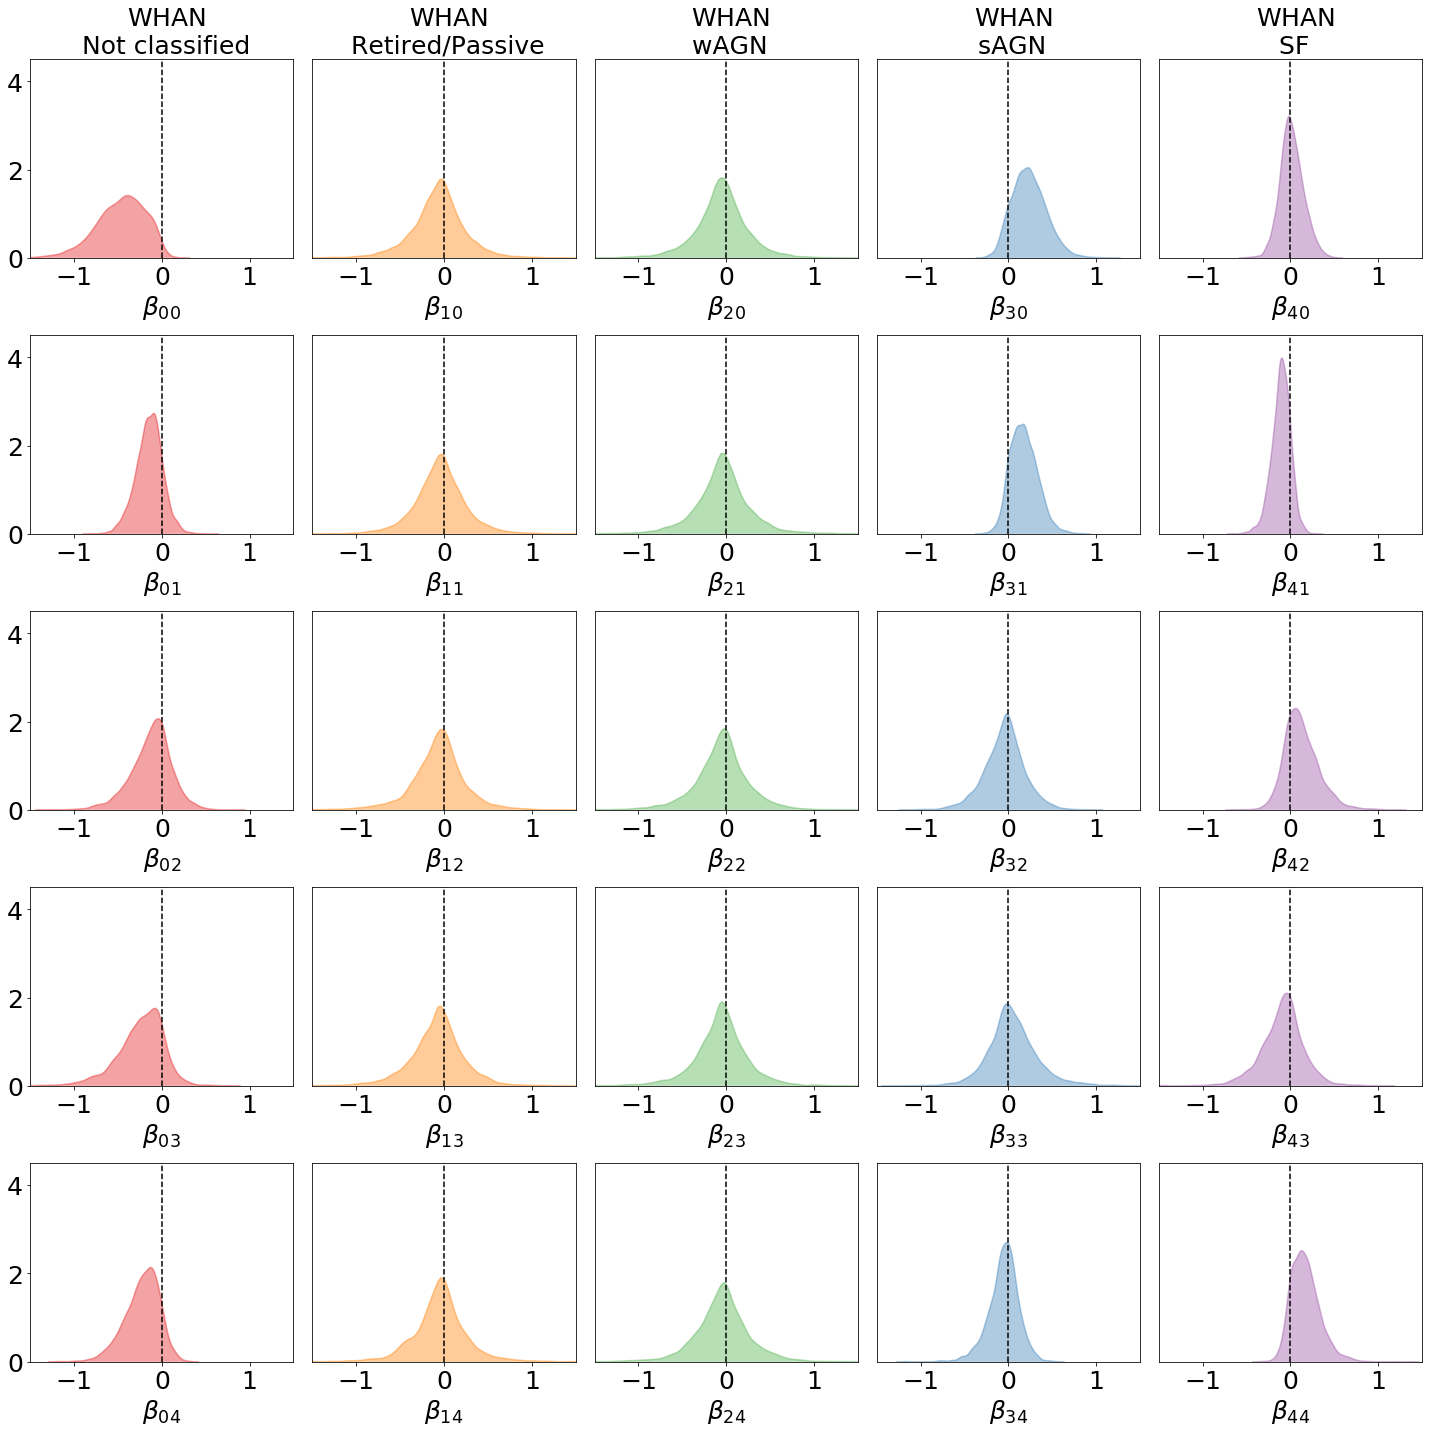

In [10]:
plt.subplots(figsize=figsize)
position = 0
for i in range(rows):
    for j in range(columns):
        position+=1
        plot = plt.subplot(columns, rows, position)
        posterior_temp = posteriors.columns.values.reshape(columns, rows)[j,i]
        sns.kdeplot(posteriors["%s" % posterior_temp].values, shade=True, alpha=alpha, color=palette[j])
        plt.axvline(x=0, linestyle="--", color='black')
        plt.tick_params('both', labelsize='25')
        plt.xlabel(r"$\beta_{%d%d}$" % (j,i), fontsize=25)
        plt.xlim([-1.5,1.5])
        plt.ylim([0,4.5])
        if (i==0):
            plt.title("$\,$ WHAN \n %s" % whan_classes[j], fontsize=25)
            if (j!=0): 
                plot.yaxis.set_visible(False)
            else: 
                plot.yaxis.set_visible(True)
        elif(i>=0)*(j==0): 
            plot.yaxis.set_visible(True)
        else: 
            plot.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, "25betas_sc_transp.png"))
plt.savefig(os.path.join(figs_path, "25betas_sc_transp.pdf"))
plt.show()

## Separating data by probability (hence, by WHAN class)

In [9]:
for i in range(len(whan_classes)):
    start = time.clock()
    j=i+1
    # reading each probability file and transposing it ---------------------------------------------------------------
    prob_temp    = pd.read_csv(os.path.join(results_path, 'sharedprior_allZ_prob0%d_sc.csv' % (j)))
    prob_temp_tr = prob_temp.transpose()
    prob_temp_tr = prob_temp_tr[1:]
    lines_size   = prob_temp_tr.values[:,0].size
    cols_size    = prob_temp_tr.values[0,:].size
    
    # creating the first column --------------------------------------------------------------------------------------
    first_col = []
    for k in range(lines_size):
        first_col.append('prob0%d[%d]' % (j, k))
    first_col = pd.DataFrame(first_col)
    first_col.columns = ['probs']
       
    # setting the header ---------------------------------------------------------------------------------------------
    prob_header = []
    for l in range(cols_size):
        prob_header.append('iter0%d' % l)
    prob_temp_tr.columns = prob_header
    
    # adding the redshift and mass columns at the end of the data frame ----------------------------------------------
    prob_temp_tr.insert(loc=0, value=first_col.values, column='probs')
    prob_temp_tr.insert(loc=(len(prob_header)+1), value=grid_split[i][:,0], column='Z')
    prob_temp_tr.insert(loc=(len(prob_header)+2), value=grid_split[i][:,1], column='LOG_STELLAR_MASS')
    
    # creating a new data frame with the median, percentiles, etc. ---------------------------------------------------
    new_stats_header = ['probs', 'median', 'mean', 'std', '2.5%', '25%', '50%', '75%', '97.5%', 'Z', 
                        'LOG_STELLAR_MASS']
    new_stats = np.zeros_like(np.array(new_stats_header[:-2]))
    for each_prob in range(lines_size):
        all_iterations = prob_temp_tr.values[each_prob, :len(prob_header)] # I'm getting 15000 iter for each prob
        median         = np.median(all_iterations[1:])
        mean           = np.mean(all_iterations[1:])
        std            = np.std(all_iterations[1:])
        percentiles    = np.percentile(a=all_iterations[1:], q=[2.5, 25, 50, 75, 97.5], interpolation='nearest')
        new_line       = np.squeeze(np.column_stack((each_prob, median, mean, std, percentiles.reshape(1,5))))
        new_stats      = np.row_stack((new_stats, new_line.reshape(1, new_line.size)))       
    new_bulk = pd.DataFrame(np.column_stack((new_stats[1:,:], grid_split[i][:, 0], grid_split[i][:, 1])))
    new_bulk.columns = new_stats_header
    new_bulk.to_csv(os.path.join(results_path, 'prob0%d_stats_allZ_sc.csv' % j), header=True)
    end = time.clock()
    print("This class took %f min to be processed" % ((end-start)/60))

This class took 4.790332 min to be processed
This class took 4.723251 min to be processed
This class took 4.766548 min to be processed
This class took 4.865159 min to be processed
This class took 5.673994 min to be processed


 Analysis to be continued in the next Jupyter Notebook. :-)